In [1]:
from __future__ import annotations

import operator
from pathlib import Path
from typing import TypedDict, List, Optional, Literal, Annotated

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_groq import ChatGroq 
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()


f:\sahil\2025-2026\Project_DS\boss_employee_agentic_rag\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# -----------------------------
# 1) Schemas
# -----------------------------
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="3–6 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(..., description="Target word count for this section (120–550).")

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False


class Plan(BaseModel):
    blog_title: str
    audience: str
    tone: str
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None  # keep if Tavily provides; DO NOT rely on it
    snippet: Optional[str] = None
    source: Optional[str] = None


class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)


class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)

In [3]:
class State(TypedDict):
    topic: str

    # routing / research
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    # workers
    sections: Annotated[List[tuple[int, str]], operator.add]  # (task_id, section_md)
    final: str

In [4]:
import os

# Explicit key selection
GROK_RESEARCH_KEY = os.getenv("GROQ_API_KEY_R")

In [5]:
# -----------------------------
# 2) LLM
# -----------------------------
llm = ChatGroq(model_name="openai/gpt-oss-120b",api_key=GROK_RESEARCH_KEY)
llm1 = ChatGoogleGenerativeAI(
    model="gemini-flash-latest",   # you can choose "gemini-2.0-flash" or others per docs :contentReference[oaicite:2]{index=2}
    temperature=0.0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


In [6]:
llm.invoke("what is the llm?, give me 1000 words")

AIMessage(content='**Large Language Models (LLMs): A Comprehensive Overview (≈\u202f1,000\u202fwords)**  \n\n---\n\n### 1. Introduction  \n\nA **Large Language Model (LLM)** is a type of artificial‑intelligence system that learns to predict and generate human‑like text. At its core, an LLM is a statistical model trained on massive amounts of written language—books, articles, web pages, code, dialogues, and more. By internalizing patterns of grammar, facts, reasoning, and even style, the model can answer questions, write essays, translate languages, create poetry, debug code, and perform countless other language‑related tasks. The “large” qualifier refers both to the sheer size of the model (often billions or even trillions of parameters) and to the volume of data used during training.\n\n---\n\n### 2. Historical Context  \n\n| Era | Key Developments | Significance |\n|-----|------------------|--------------|\n| **1950s‑80s** | Early rule‑based NLP, symbolic parsing | Demonstrated that 

In [7]:
# -----------------------------
# 3) Router (decide upfront)
# -----------------------------
ROUTER_SYSTEM = """You are a routing module for a Company's research planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 2 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "stock market" or "comapanies name").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""

def router_node(state: State) -> dict:
    
    topic = state["topic"]
    decider = llm.with_structured_output(RouterDecision)
    decision = decider.invoke(
        [
            SystemMessage(content=ROUTER_SYSTEM),
            HumanMessage(content=f"Topic: {topic}"),
        ]
    )
    print("router_node")
    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
    }

def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"

In [8]:
"""New added"""
import sys
sys.path.append(r"F:\sahil\2025-2026\Project_DS\boss_employee_agentic_rag\backend")
q = ""
from agentic_rag.graph_pipeline import run_agent
def agentic_rag_tool(query: str):
    q =  llm.invoke(f"You have to use this query:{query}, and generate a simple query to fetch the data using the provided query , do not add any thing extra.")
    
    result = run_agent(q.content)
    return "companies data: " + result['context']

a  =agentic_rag_tool("What are the vision,mission, goals of the Smart tech ?")
print(a)


{'use_sql': True, 'use_vector': False, 'use_graph': False, 'sql_intent': {'select': ['*'], 'filters': {'year': 2023}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': 15000}, 'vector_intent': {'topics': []}, 'graph_intent': {'entities': [], 'relations': []}}
{'use_sql': True, 'use_vector': False, 'use_graph': False, 'sql_intent': {'select': ['*'], 'filters': {'year': 2023}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': 15000}, 'vector_intent': {'topics': []}, 'graph_intent': {'entities': [], 'relations': []}}


2026-02-04 18:22:58,033 - backend.agentic_rag.graph_tool - ERROR - ✗ Failed to connect to Neo4j: Did not find url, please add an environment variable `NEO4J_URI` which contains it, or pass `url` as a named parameter.
2026-02-04 18:22:58,036 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: cpu
2026-02-04 18:22:58,039 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2026-02-04 18:23:01,038 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2026-02-04 18:23:01,143 - backend.agentic_rag.graph_tool - INFO - ✓ Vector store loaded successfully
2026-02-04 18:23:02,507 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'Smart tech']}, 'graph_intent': {'entities': [], 'relations': []}}
{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'Smart tech']}, 'graph_intent': {'entities': [], 'relations': []}}


2026-02-04 18:23:03,748 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'query': 'What are the vision,mission, goals of the Smart tech ?', 'plan': {'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'Smart tech']}, 'graph_intent': {'entities': [], 'relations': []}}, 'context': '[VECTOR]\nspecific period \n• Policies may be updated periodically; employees will be notified of significant changes \n• Questions about policies should be directed to the Human Resources department \n• Violation of company policies may result in disciplinary action, up to and including \ntermination \n1.3 Our Mission, Vision, and Values \nMission: To enhance everyday digital experiences through affordable smart technology. \nVision: To become a leading wearable technology brand in emerging markets.\n\x7f Profitability: 8%+ net margin\n\x7f Team Size: 800+ employees\nStrategic Ambitions:\n\x7f Become a com

2026-02-04 18:23:06,387 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'Smart tech']}, 'graph_intent': {'entities': [], 'relations': []}}
{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'Smart tech']}, 'graph_intent': {'entities': [], 'relations': []}}


2026-02-04 18:23:07,208 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'query': 'What are the vision,mission, goals of the Smart tech ?', 'plan': {'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'Smart tech']}, 'graph_intent': {'entities': [], 'relations': []}}, 'context': '[VECTOR]\nspecific period \n• Policies may be updated periodically; employees will be notified of significant changes \n• Questions about policies should be directed to the Human Resources department \n• Violation of company policies may result in disciplinary action, up to and including \ntermination \n1.3 Our Mission, Vision, and Values \nMission: To enhance everyday digital experiences through affordable smart technology. \nVision: To become a leading wearable technology brand in emerging markets.\n\x7f Profitability: 8%+ net margin\n\x7f Team Size: 800+ employees\nStrategic Ambitions:\n\x7f Become a com

2026-02-04 18:23:07,830 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-04 18:23:08,847 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'SmartTech']}, 'graph_intent': {'entities': [], 'relations': []}}
{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['vision', 'mission', 'goals', 'SmartTech']}, 'graph_intent': {'entities': [], 'relations': []}}


2026-02-04 18:23:09,886 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


companies data: [VECTOR]
specific period 
• Policies may be updated periodically; employees will be notified of significant changes 
• Questions about policies should be directed to the Human Resources department 
• Violation of company policies may result in disciplinary action, up to and including 
termination 
1.3 Our Mission, Vision, and Values 
Mission: To enhance everyday digital experiences through affordable smart technology. 
Vision: To become a leading wearable technology brand in emerging markets.
 Profitability: 8%+ net margin
 Team Size: 800+ employees
Strategic Ambitions:
 Become a complete wearables ecosystem brand
 Establish premium brand equity
 Pan-Asia presence (10+ countries)
 Technology innovator reputation
 Sustainable & responsible business leader
Moonshot Projects:
 AR/VR consumer products
 Health-tech platform with AI diagnostics
 Smart home integration
 Wearable payments ecosystem
Risk & Contingency Planning
Downside Scenario Planning:
Technology & 

In [9]:
print(a)

companies data: [VECTOR]
specific period 
• Policies may be updated periodically; employees will be notified of significant changes 
• Questions about policies should be directed to the Human Resources department 
• Violation of company policies may result in disciplinary action, up to and including 
termination 
1.3 Our Mission, Vision, and Values 
Mission: To enhance everyday digital experiences through affordable smart technology. 
Vision: To become a leading wearable technology brand in emerging markets.
 Profitability: 8%+ net margin
 Team Size: 800+ employees
Strategic Ambitions:
 Become a complete wearables ecosystem brand
 Establish premium brand equity
 Pan-Asia presence (10+ countries)
 Technology innovator reputation
 Sustainable & responsible business leader
Moonshot Projects:
 AR/VR consumer products
 Health-tech platform with AI diagnostics
 Smart home integration
 Wearable payments ecosystem
Risk & Contingency Planning
Downside Scenario Planning:
Technology & 

In [10]:
# -----------------------------
# 4) Research (Tavily) 
# -----------------------------
def _tavily_search(query: str, max_results: int =  1) -> List[dict]:
    
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke({"query": query})

    normalized: List[dict] = []
    for r in results or []:
        normalized.append(
            {
                "title": r.get("title") or "",
                "url": r.get("url") or "",
                "snippet": r.get("content") or r.get("snippet") or "",
                "published_at": r.get("published_date") or r.get("published_at"),
                "source": r.get("source"),
            }
        )
    return normalized


RESEARCH_SYSTEM = """You are a research synthesizer for research writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
  If missing or unclear, set published_at=null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL.
"""

def research_node(state: State) -> dict:

    # take the first 10 queries from state
    queries = (state.get("queries", []) or [])
    max_results = 2

    raw_results: List[dict] = []

    for q in queries:
        raw_results.extend(_tavily_search(q, max_results=max_results))

    if not raw_results:
        return {"evidence": []}
    topic = state['topic']
    vector_result = agentic_rag_tool(topic)

    extractor = llm.with_structured_output(EvidencePack)
    pack = extractor.invoke(
        [
            SystemMessage(content=RESEARCH_SYSTEM),
            HumanMessage(content=f"Raw results:\n{raw_results}"),
        ]
    )

    # Deduplicate by URL
    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e
    print("research")
    return {"evidence": list(dedup.values())}

In [19]:
# -----------------------------
# 5) Orchestrator (Plan)
# -----------------------------
ORCH_SYSTEM = """You are a senior company research analyst and professional research writer.
Your job is to produce a highly actionable outline for a company-level research report.

Hard requirements:
- Create 2 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 3–6 bullets that are concrete, specific, and non-overlapping
  3) target word count (120–550)

Quality bar:
- Assume the reader is a business, strategy, or research stakeholder; use precise and professional terminology.
- Bullets must be actionable: analyze/compare/benchmark/evaluate/identify/validate.
- Focus on company-level insights such as:
  * business model and revenue drivers
  * market positioning and competitive landscape
  * growth strategy, risks, and opportunities
  * operational, regulatory, or geographic considerations
- Ensure logical flow from high-level context to evidence-backed insights.
- Avoid code, implementation details, or developer-centric instructions.
- Prioritize clarity, neutrality, and decision-useful insights over narrative flair.

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (company performance, market trends, financial metrics, partnerships, acquisitions, regulatory events).
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book:
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.

"""

def orchestrator_node(state: State) -> dict:
    planner = llm.with_structured_output(Plan)

    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")

    plan = planner.invoke(
        [
            SystemMessage(content=ORCH_SYSTEM),
            HumanMessage(
                content=(
                    f"Topic: {state['topic']}\n"
                    f"Mode: {mode}\n\n"
                    f"Evidence (ONLY use for fresh claims; may be empty):\n"
                    f"{[e.model_dump() for e in evidence][:16]}"
                )
            ),
        ]
    )
    print("orch")
    return {"plan": plan}

In [20]:
# -----------------------------
# 6) Fanout
# -----------------------------
def fanout(state: State):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

In [21]:
# -----------------------------
# 7) Worker (write one section)
# -----------------------------
WORKER_SYSTEM = """You are a senior company research analyst and professional research writer.
Write ONE section of a research blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker_node(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()
    print("worker")
    return {"sections": [(task.id, section_md)]}

In [22]:
# -----------------------------
# 8) Reducer (merge + save)
# -----------------------------
def reducer_node(state: State) -> dict:

    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    filename = f"{plan.blog_title}.md"
    Path(filename).write_text(final_md, encoding="utf-8")
    print("reducer_node")
    return {"final": final_md}

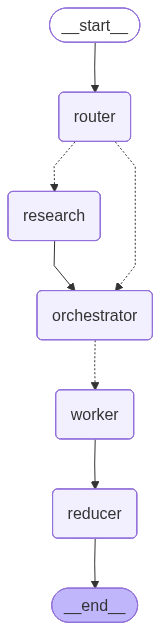

In [23]:
# -----------------------------
# 9) Build graph
# -----------------------------
g = StateGraph(State)
g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator_node)
g.add_node("worker", worker_node)
g.add_node("reducer", reducer_node)

g.add_edge(START, "router")
g.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
g.add_edge("research", "orchestrator")

g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()
app

In [24]:
# -----------------------------
# 10) Runner
# -----------------------------
def run(topic: str):
    out = app.invoke(
        {
            "topic": topic,
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

    return out

In [29]:
#run("Write a blog on Open Source LLMs in 2026")
a = run("Compare Smart Tech Technologies'  in FY2024 with our top 3 competitors (Boat, Noise, and Samsung).What is the major difference between us and them? ")

2026-02-04 18:29:15,730 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


router_node


2026-02-04 18:29:25,523 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-04 18:29:26,770 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['Smart Tech Technologies financial metrics 2024', 'Boat financial metrics 2024', 'Noise financial metrics 2024', 'Samsung financial metrics 2024', 'company revenue 2024', 'net income 2024', 'market share 2024']}, 'graph_intent': {'entities': [], 'relations': []}}
{'use_sql': False, 'use_vector': True, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': ['Smart Tech Technologies financial metrics 2024', 'Boat financial metrics 2024', 'Noise financial metrics 2024', 'Samsung financial metrics 2024', 'company revenue 2024', 'net income 2024', 'market share 2024']}, 'graph_intent': {'entities': [], 'relations': []}}


2026-02-04 18:29:28,107 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-04 18:29:30,274 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


research


2026-02-04 18:29:32,356 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


orch


2026-02-04 18:29:35,581 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


worker


2026-02-04 18:29:40,053 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


worker
reducer_node


In [30]:
print(a['final'])

# FY2024 Competitive Landscape: Smart Tech Technologies vs. Boat, Noise, and Samsung

## FY2024 Financial and Market Performance Comparison

- **FY2024 revenue, YoY growth, and profit margins**  
  - *Smart Tech Technologies*: FY2024 revenue ___ USD bn, YoY growth ___ %, profit margin ___ % – **[Research needed – cite audited statements or market database]**.  
  - *Boat*: FY2024 revenue ___ USD bn, YoY growth ___ %, profit margin ___ % – **[Research needed – cite two independent sources]**.  
  - *Noise*: FY2024 revenue ___ USD bn, YoY growth ___ %, profit margin ___ % – **[Research needed – cite two independent sources]**.  
  - *Samsung*: FY2024 revenue reported at **≈ $84 bn** with a **3.2 % YoY increase** and **profit margin of 12.5 %** ([Samsung's 2024 Financial Report](https://www.technetbooks.com/2025/01/samsungs-2024-financial-report-record.html); [Samsung Sales statistics](https://tridenstechnology.com/samsung-sales-statistics/)).  

- **Share of the global smart‑home market*

AttributeError: type object 'State' has no attribute 'final'

In [67]:
for event in app.stream(State):
    print(event)

InvalidUpdateError: Expected dict, got <class '__main__.State'>
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE

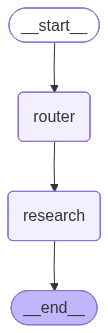

In [81]:
g = StateGraph(State)
g.add_node("router", router_node)
g.add_node("research", research_node)

g.add_edge(START, "router")
g.add_edge("router", "research")
g.add_edge("research", END)

app_1= g.compile()
app_1

In [19]:
out = app.invoke(
        {
            "topic": "Write a blog on Open Source LLMs in 2026",
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

2026-02-03 18:22:48,205 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


router_node


2026-02-03 18:22:55,460 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-03 18:22:56,484 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'use_sql': False, 'use_vector': False, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': []}, 'graph_intent': {'entities': [], 'relations': []}}
{'use_sql': False, 'use_vector': False, 'use_graph': False, 'sql_intent': {'select': [], 'filters': {}, 'group_by': [], 'metrics': [], 'aggregation': None, 'limit': None}, 'vector_intent': {'topics': []}, 'graph_intent': {'entities': [], 'relations': []}}


2026-02-03 18:22:58,435 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-03 18:22:59,758 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


research


2026-02-03 18:23:05,082 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-03 18:23:05,137 - google_genai.models - INFO - AFC is enabled with max remote calls: 10.


orch


2026-02-03 18:23:15,777 - httpx - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-flash-latest:generateContent "HTTP/1.1 200 OK"


worker
reducer_node
